## Import Necessary Libraries and Modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.svm import LinearSVC, SVC 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, ParameterGrid


In [2]:
sns.set_theme(palette='muted')

## SVM

In [3]:
#code adapted from assignemt 4

def rand_clothes(path, number, random_state):
    '''Function to load the images and randomly select a given size of images
        path: which folder the images are in
        number: how many images to to select
        random_state: seed to make the results reproducible
    '''
    #set a seed
    np.random.seed(random_state)
    
    #read the files from the path and randomly select a given number
    files = os.scandir(path)
    files = [i.name.lower() for i in files]
    return np.random.choice(files, size=number, replace=False)

files_j = rand_clothes("Clothes/Jersey", 600, 123)    
files_s = rand_clothes("Clothes/Shirt", 600, 234)

In [4]:
#code adopted from LBA assignment
def img_to_arr(imgs, path):
    #list to store images
    flattened = []
    
    # for each image combine the name with path 
    for img in imgs:
        # open it as a read file in binary mode
        with open(path+img, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                #cover = resizeimage.resize_cover(image, [512, 512])
                cover = image.resize((128,128))
                flattened.append((np.array(cover).flatten(), 0))
                
    # Flatten it once more
    flattened = np.asarray(flattened)
    
    return flattened

In [5]:
#convert the images to arrays
jerseys = img_to_arr(files_j, 'Clothes/Jersey/')
shirts = img_to_arr(files_s, 'Clothes/Shirt/')

/Users/stevedavieswambui/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### EDA and Data Cleaning

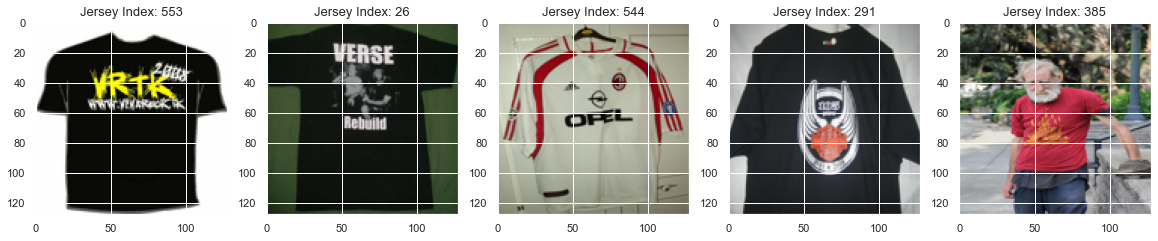

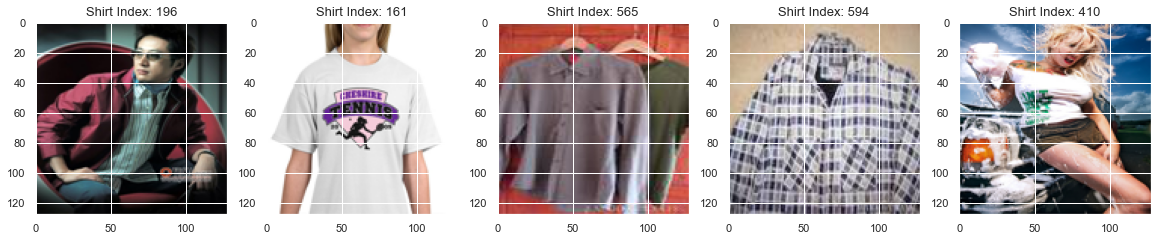

In [6]:
#display some of the images
# initializing the subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 15))

#flatteen the axis
axs = axs.flatten()

# look at random selected jerseys
range_j = np.random.randint(0, len(jerseys), 5)
for p, ax in zip(range_j, axs):
    
    #resize the matrix to the same shape as the images and rotate
    ax.imshow(Image.fromarray(jerseys[p,0].reshape(128,128,3), 'RGB'))
    ax.set_title(f'Jersey Index: {p+1}', size=13)
    
    
# initializing the subplots
fig, axs1 = plt.subplots(1, 5, figsize=(20, 15))

#flatteen the axis
axs1 = axs1.flatten()
# look at random selected shirts
range_s = np.random.randint(0, len(shirts), 5)
for p, ax in zip(range_s, axs1):
    
    #resize the matrix to the same shape as the images and rotate
    ax.imshow(Image.fromarray(shirts[p,0].reshape(128,128,3), 'RGB'))
    ax.set_title(f'Shirt Index: {p+1}', size=13)
    
plt.show()

In [7]:
# Declare which are the X and Y inputs for jerseys
X_js = jerseys[:,0]
Y_js = jerseys[:,1]

# Use np.stack to put the data into the right dimension
X_js = np.stack(X_js)
Y_js = np.stack(Y_js)

# Declare which are the X and Y inputs for shirts
X_sh = shirts[:,0]
Y_sh = shirts[:,1]

# Use np.stack to put the data into the right dimension
X_sh = np.stack(X_sh)
Y_sh = np.stack(Y_sh)

In [8]:
#convert the arrays to dataframes, jerseys
df_js = pd.DataFrame(X_js)
df_js['target'] = Y_js

#convert the arrays to dataframes, jerseys
df_sh = pd.DataFrame(X_sh)
df_sh['target'] = Y_sh
df_sh['target'] = 1 #define the shirts to be the class 1

data = pd.concat([df_js, df_sh])
data

,0,1,2,3,4,5,6,7,8,9,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,target
0,150,184,66,153,185,101,165,202,196,165,...,107,92,84,122,78,59,159,105,80,0
1,97,104,113,98,108,124,94,100,111,90,...,101,85,61,94,82,61,74,63,48,0
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
3,4,12,9,5,11,9,6,11,10,7,...,7,13,11,6,12,12,5,13,12,0
4,229,224,218,229,224,218,229,224,218,231,...,240,240,238,250,250,248,248,248,246,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,204,204,204,204,204,204,204,204,204,204,...,204,204,204,204,204,204,204,204,204,1
596,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
597,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
598,159,145,119,164,150,124,162,148,123,161,...,162,151,131,162,150,130,162,151,131,1


### Model Development and Training

Similar to assignment 4, I will use SGD Classifier which allows online learning and saves on RAM.

In [9]:
# drop the target variable 
X = data.drop(['target'], axis=1)

# convert the target variable to int type
y = data['target'].astype("int64")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  4.1min finished
[Parallel(n_jobs=-1)]: Using

-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    6.8s finished


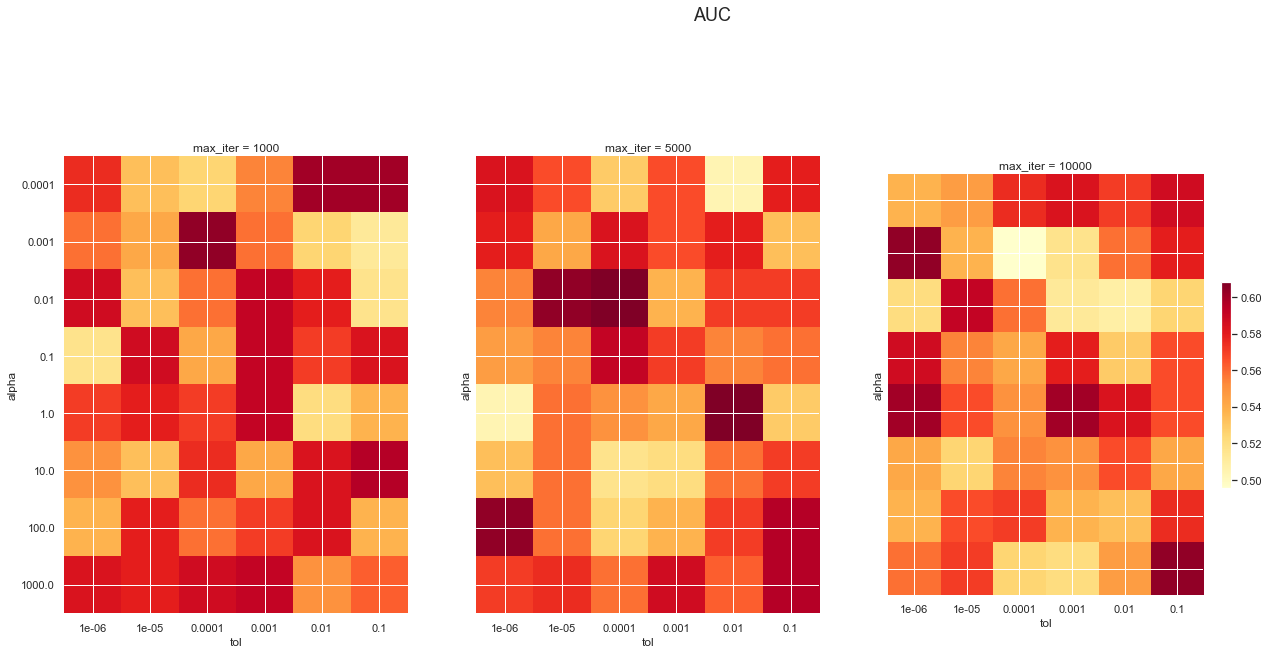

SGDClassifier(alpha=0.01, max_iter=5000, n_jobs=-1, tol=0.0001) 0.6083333333333334


In [10]:
#code adapted from https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4

#tune the hyperparameters, need to pip install parfit
import parfit.parfit as pf

#create the grid of hyperparameters to tune
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #tolerance
    'max_iter': [1000, 5000, 10000], # number of epochs
    'loss': ['hinge'], # svm,
    'penalty': ['l2'],
    'n_jobs': [-1]
}

#specify the model and call the parameter grid function
model = SGDClassifier
paramGrid = ParameterGrid(grid)

#fit the parameters and get the best set of parameters
bestModel, bestScore, allModels, allScores = pf.bestFit(model, paramGrid,
           X_train, y_train, X_test, y_test, 
           metric = roc_auc_score,
           scoreLabel = "AUC")

print(bestModel, bestScore)

In [11]:
#construct the pipeline
sc = StandardScaler()

#initialize the models with the best parameters from tuning
svm_sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000, 
                        tol=-0.01, random_state=0, alpha=10.0)

#standadize data, initiialize classifiers
svc_lin = Pipeline([
     ('std_scaler', sc),
     ('classifier', svm_sgd)
 ])

In [12]:
# fit the model to the data
svc_lin.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('classifier',
                 SGDClassifier(alpha=10.0, max_iter=10000, random_state=0,
                               tol=-0.01))])

In [13]:
svc_poly = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=2,
                                                 max_iter=20000, 
                                                 random_state=2))
svc_rbf = make_pipeline(StandardScaler(), SVC(kernel="rbf", max_iter=20000, 
                                                random_state=3))


In [14]:
# fit the other models to the data
svc_poly.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(max_iter=20000, random_state=3))])

In [15]:
# predict on the testing set
preds_svc_lin = svc_lin.predict(X_test)
preds_svc_poly = svc_poly.predict(X_test)
preds_svc_rbf = svc_rbf.predict(X_test)

#print the accuracy scores
print(f"Accuracy score linear SVC: {round(accuracy_score(y_test, preds_svc_lin), 2)}")
print(f"Accuracy score polynomial SVC: {round(accuracy_score(y_test, preds_svc_poly), 2)}")  
print(f"Accuracy score rbf SVC: {round(accuracy_score(y_test, preds_svc_rbf), 2)}")  

Accuracy score linear SVC: 0.62
Accuracy score polynomial SVC: 0.61
Accuracy score rbf SVC: 0.67


The SVC with the rbf kernel has the best accuracy which means that using radial basis finds the best representation of the data as compared to linear and polynomial. 

## Deep Learnign with CNN

I try both a basic CNN and one that uses transfer learning from VGG16 to see if the transfer learning improves performance. 

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout


from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

In [17]:
#declate the path, batch_size, target_size
path = "Clothes"
batch_size = 128
target_size = (224, 224)

In [18]:
#split the images into training and validation and rescale them
image_gen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

#generate the training images from directroy split above
train_gen = image_gen.flow_from_directory(
    path,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode='rgb',
    classes=None, subset="training"
)

#generate the validation set from directory split
val_gen = image_gen.flow_from_directory(
    path,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'binary',
    color_mode='rgb',
    classes=None, subset="validation"
)

Found 2242 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


### Basic CNN (No Transfer Learning)

In [19]:
# max the loss during training
# training will be stopped after 5 epochs with no improvement
early_stop = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=8,
                                               verbose=1,
                                               mode="max",
                                               restore_best_weights=True)

# build a sequential model 
model = Sequential()
model.add(InputLayer(input_shape=(*target_size, 3)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())

# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=1, activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

# fit on data for 30 epochs
basic_cnn = model.fit_generator(train_gen, epochs=30, validation_data=val_gen, callbacks=[early_stop])

Epoch 1/30
18/18 [==============================] - 104s 6s/step - loss: 0.7604 - accuracy: 0.5459 - val_loss: 0.6862 - val_accuracy: 0.5607
Epoch 2/30
18/18 [==============================] - 105s 6s/step - loss: 0.6908 - accuracy: 0.5872 - val_loss: 0.6823 - val_accuracy: 0.5339
Epoch 3/30
18/18 [==============================] - 97s 5s/step - loss: 0.6850 - accuracy: 0.5860 - val_loss: 0.7013 - val_accuracy: 0.5268
Epoch 4/30
18/18 [==============================] - 92s 5s/step - loss: 0.6461 - accuracy: 0.6319 - val_loss: 0.7033 - val_accuracy: 0.5357
Epoch 5/30
18/18 [==============================] - 97s 5s/step - loss: 0.6529 - accuracy: 0.6140 - val_loss: 0.6843 - val_accuracy: 0.5286
Epoch 6/30
18/18 [==============================] - 93s 5s/step - loss: 0.6412 - accuracy: 0.6383 - val_loss: 0.7358 - val_accuracy: 0.5250
Epoch 7/30
18/18 [==============================] - 88s 5s/step - loss: 0.6188 - accuracy: 0.6599 - val_loss: 0.7009 - val_accuracy: 0.5304
Epoch 8/30
18/18 [

In [20]:
df = pd.DataFrame(basic_cnn.history)
print(f"cross entropy: {np.round(df['loss'].max(), 2)}")
print(f"accuracy: {np.round(df['accuracy'].max(), 4)*100}%")
print(f"Validation cross entropy: {np.round(df['val_loss'].max(), 2)}")
print(f"Validation accuracy: {np.round(df['val_accuracy'].max(), 4)*100}%")

cross entropy: 0.73
accuracy: 66.19%
Validation cross entropy: 0.94
Validation accuracy: 56.07%


In [21]:
df

,loss,accuracy,val_loss,val_accuracy
0,0.729891,0.576717,0.686247,0.560714
1,0.688043,0.595004,0.682261,0.533929
2,0.667488,0.600803,0.701340,0.526786
3,0.650471,0.624888,0.703272,0.535714
4,0.638307,0.625781,0.684335,0.528571
5,0.629012,0.638715,0.735806,0.525000
6,0.625866,0.652096,0.700935,0.530357
7,0.623958,0.641838,0.781513,0.525000
8,0.610824,0.661909,0.943386,0.525000


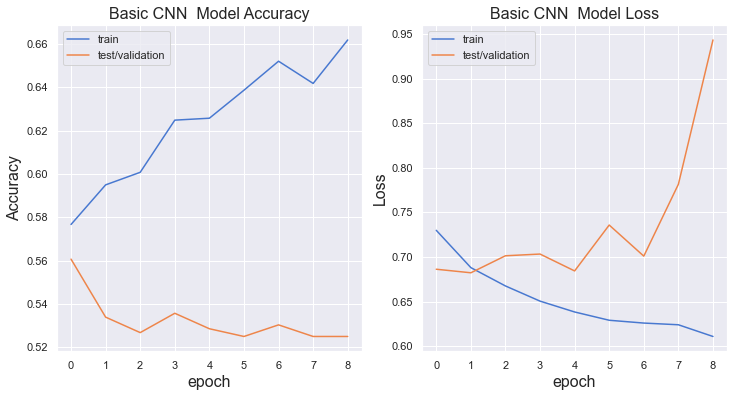

In [64]:
#initializing subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# accuracy
axs[0].plot(df['accuracy'])
axs[0].plot(df['val_accuracy'])
axs[0].set_title('Basic CNN  Model Accuracy', size=16)
axs[0].set_ylabel('Accuracy', size=16)
axs[0].set_xlabel('epoch', size=16)
axs[0].legend(['train', 'test/validation'], loc='upper left')
#plt.show();

# loss
axs[1].plot(df['loss'])
axs[1].plot(df['val_loss'])
axs[1].set_title('Basic CNN  Model Loss', size=16)
axs[1].set_ylabel('Loss', size=16)
axs[1].set_xlabel('epoch', size=16)
axs[1].legend(['train', 'test/validation'], loc='upper left')
plt.show();

### Transfer Learning with VGG16

In [23]:
# include top = False to remove the softmax layer trained on theImageNet dataset
base_model = VGG16(include_top=False, weights='imagenet',
                        input_shape=(*target_size, 3))

#check the model summary
base_model.summary()

# Then, freeze the base model.
base_model.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
# code adapted from PCW Session 18

# instantiate a Keras tensor (object, which we augment with certain attributes 
# that allow us to build a Keras model just by knowing the inputs and outputs of the model)
inp = base_model.input

# add the last layers for our image classification problem
x = layers.Flatten()(base_model.output)
# prevents overfitting
x = layers.Dropout(0.25)(x)
# prediction layer
x = layers.Dense(1, activation="sigmoid")(x)  
final_model = keras.models.Model(inp, x)

# freeze all the lower level layers
for layer in final_model.layers[:len(base_model.layers)]:
    layer.trainable = False

# compile the model 
final_model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

final_model.summary()

#freeze model
final_model.trainable=False

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
# train the model with input from VGG16
vgg_train = final_model.fit(train_gen, batch_size=batch_size,
                       validation_data=val_gen,
                       epochs=20,
                       callbacks=[early_stop])

Epoch 1/20
18/18 [==============================] - 976s 54s/step - loss: 0.8534 - accuracy: 0.5264 - val_loss: 0.5166 - val_accuracy: 0.7554
Epoch 2/20
18/18 [==============================] - 907s 51s/step - loss: 0.5904 - accuracy: 0.6916 - val_loss: 0.4681 - val_accuracy: 0.7875
Epoch 3/20
18/18 [==============================] - 912s 51s/step - loss: 0.5475 - accuracy: 0.7282 - val_loss: 0.4829 - val_accuracy: 0.7643
Epoch 4/20
18/18 [==============================] - 893s 50s/step - loss: 0.5265 - accuracy: 0.7326 - val_loss: 0.5090 - val_accuracy: 0.7286
Epoch 5/20
18/18 [==============================] - 902s 51s/step - loss: 0.5442 - accuracy: 0.7161 - val_loss: 0.4595 - val_accuracy: 0.7875
Epoch 6/20
18/18 [==============================] - 855s 48s/step - loss: 0.5186 - accuracy: 0.7508 - val_loss: 0.4419 - val_accuracy: 0.7893
Epoch 7/20
18/18 [==============================] - 808s 45s/step - loss: 0.5053 - accuracy: 0.7523 - val_loss: 0.4423 - val_accuracy: 0.8089
Epoch 

In [26]:
df1 = pd.DataFrame(vgg_train.history)
print(f"cross entropy: {np.round(df1['loss'].max(), 2)}")
print(f"accuracy: {np.round(df1['accuracy'].max(), 4)*100}%")
print(f"Validation cross entropy: {np.round(df1['loss'].max(), 2)}")
print(f"Validation accuracy: {np.round(df1['accuracy'].max(), 4)*100}%")

cross entropy: 0.77
accuracy: 77.7%
Validation cross entropy: 0.77
Validation accuracy: 77.7%


In [27]:
df1

,loss,accuracy,val_loss,val_accuracy
0,0.774329,0.568689,0.516648,0.755357
1,0.593913,0.690901,0.468104,0.787500
2,0.556841,0.716325,0.482914,0.764286
3,0.528002,0.733274,0.508985,0.728571
4,0.541150,0.718555,0.459516,0.787500
5,0.522103,0.741748,0.441875,0.789286
6,0.512270,0.749777,0.442273,0.808929
7,0.513133,0.745317,0.526189,0.691071
8,0.502467,0.744871,0.474274,0.753571
9,0.495607,0.752007,0.452069,0.798214


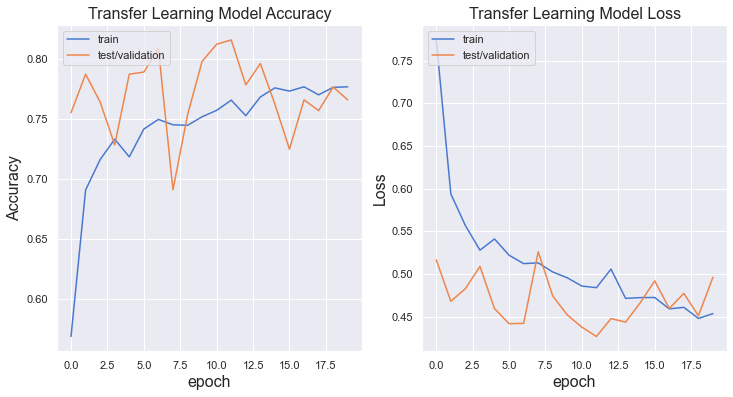

In [63]:
#initializing subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# accuracy
axs[0].plot(df1['accuracy'])
axs[0].plot(df1['val_accuracy'])
axs[0].set_title('Transfer Learning Model Accuracy', size=16)
axs[0].set_ylabel('Accuracy', size=16)
axs[0].set_xlabel('epoch', size=16)
axs[0].legend(['train', 'test/validation'], loc='upper left')
#plt.show();

# loss
axs[1].plot(df1['loss'])
axs[1].plot(df1['val_loss'])
axs[1].set_title('Transfer Learning Model Loss', size=16)
axs[1].set_ylabel('Loss', size=16)
axs[1].set_xlabel('epoch', size=16)
axs[1].legend(['train', 'test/validation'], loc='upper left')
plt.show();

### Discussion

Given it is a binary classification problem, I use `binary cross-entropy` as a loss function. The probability of every image belonging to one or the other class is calculated and cross-entropy can be used to determine the difference between 2 probability distributions: true and predicted. We are interested in minimizing the loss function to make the expected and predicted probabilities similar for every class label. 

For the basic CNN, the training and validation accuracies both generally increase with the training accuracy being highest at 66% and the validation accuracy being highest at 56% (although this was at the beginning and it only dropped going forward). The model seems to be learning the data well and but seems to be overfitting quite a lot given the measures used to prevent overfitting. Specifically, I use early stopping and dropout. Dropout means that for every layer and iteration, we drop a certain percentage of neurons which means that the model won't learn complicated relationships that are are only specific to the training data but not to unseen data. Early stopping uses the validation where if the loss on the validation data (data not trained on) keeps increasing, or does not decrease further, we stop the epochs because it means the model has started to overfit. All the same, it is evident from the plots that overfitting is a big problem and so we move to the VGG16 transfer learning and see if we have better results

For the model with transfer learning, the accuracy trends for training and validation vary slightly with the highest training accuracy being 82% and validation accuracy being 82%. The model seems to be learning the data well but it may have started overfitting as seen in the sudden drop in the validation accuracy. Similar to the basic CNN, I use dropout and early stopping to prevent further overfitting. Removing more of the Dense layers and leaving only prediction layer also significantly improved the model accuracy. Transfer learning clearly helps because we achieve high accuracy within just 6 epochs as compared to the basic CNN. The plots shows that the loss and accuracy were finally plateauing (converging) when the model stopped. There is significantly less overfitting in this model which shows that both trnasfer learning and using fewer layers helps for generalizability.

## Shallow vs Deep Learning

CNNs (deep learning) clearly outperform SVM (shallow learning). Although it takes longer to train the neural networks, the fact that the image size for SVMs is smaller, we use transfer learning and there is significantly more vector computations for CNNs, the computation time difference does not make up for the accuracy level. Other than the SGD classifier for linear SVM, the other two SVMs are actually slow for the accuracy aquired with the highest being 67% which is about the same as a basic CNN that doesn't take to long to train. Given the large amount of data, non-linear relationships within images and possible unobservable features, the best choice for classifying the images is the CNNs which can be fine-tuned and stopped early saving on computational time while achieving high accuracy. Transfer learning even helps better because it uses a pretrained model which has proven to work very well for images and therefore gives confidence in the results and accuracy.